# Performance Analysis of FC Barcelona (2014–2025) 
## A Data-Driven Investigation into Performance, Efficiency, and Financial Constraints

## Introduction
- Analyze FC Barcelona’s performance trends across La Liga & UEFA Champions League, combined with financial indicators (transfer spending & salary cap), to understand how squad efficiency and financial constraints shaped their competitive trajectory.
- Research Question:
  
    > *How did FC Barcelona go from European dominance to financial and competitive instability, and what factors explain their decline and recovery?*

## Import Libraries

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

## Data Overview
- For this project, I use multiple datasets collected from reliable football statistics and financial sources:
  - **La Liga season-level Stats (2014–2025)** - Contains season-by-season performance metrics such as Goals For (GF), Goals Against (GA), Expected Goals (xG), Goal Difference (GD), and final league rank.  
  - **Deeper ball situations breakdown** - open play, free kicks, corners
  - **UEFA Champions League Stats (2014–2025)** - Includes stage progression (Group, Round of 16, QF, SF, Final), goals, and match outcomes.
  - **Transfer Market Data** - Includes transfer spend per season (in €M).  
  - **Squad Cost Limit Data** - Published by La Liga, defines the maximum amount clubs can spend on salaries, amortization, and agent fees.
- Together, these datasets enable both performance and financial analysis of FC Barcelona over the last decade.

### Load Data


In [121]:
# scrape and load needed dataset for analysis
df1 = pd.read_html('https://fbref.com/en/squads/206d90db/history/Barcelona-Stats-and-History#all_comps_fa_club_league', attrs={"id" : "comps_fa_club_league"})[0]
df1.to_csv('./data/raw/la_liga_stats.csv')
df2 = pd.read_html('https://fbref.com/en/squads/206d90db/history/Barcelona-Stats-and-History#all_comps_fa_club_league', attrs={"id" : "comps_intl_club_cup"})[0]
df2.to_csv('./data/raw/champions_league_stats.csv')
df3 = pd.read_csv('./data/processed/fcb_deeper_stats.csv')
df4 = pd.read_csv('./data/processed/squad_cost_limit.csv')
df5 = pd.read_csv('./data/processed/transfer_spending.csv')


### Data Cleaning & Transformation

In [ ]:
# drop irrelevant columns and rows
df1 = df1.drop([0] + list(range(12, 38))).reset_index(drop=True)
df1 = df1.drop(['Country', 'Attendance', 'Top Team Scorer', 'Goalkeeper' , 'Notes'], axis=1)
indices_to_drop = df3[df3['Ball Situation'] == 'Set piece'].index
df3 = df3.drop(indices_to_drop).reset_index(drop=True)
df4 = df4.drop(list(range(0, 5))).reset_index(drop=True)

# data transformation
df1.rename(columns={"Comp" : "Domestic Comp", "LgRank" : "Domestic Rank", "MP" : "Domestic Match Played", 
                    "W" : "Domestic W", "D" : "Domestic D", "L" : "Domestic L", "GF" : "Total GF", 
                    "GA" : "Total GA", "GD" :"Domestic GD", "Pts" : "Domestic Pts"}, inplace=True)
df1["Season"] = df1["Season"].str.split("-").apply(lambda x: x[0][2:] + "/" + x[1][2:])
df1 = df1.sort_values("Season").reset_index(drop=True)
merged_df = pd.merge(df1, df3, on=['Season'], how='right')
merged_df['Domestic Rank'] = merged_df['Domestic Rank'].str[:-2].astype('int')

# strip any space if any
merged_df.columns = merged_df.columns.str.strip()
merged_df.to_csv('./data/processed/laliga_season_level_stats.csv')

# clean dataset
df2 = df2.drop([0] + list(range(14, 38))).reset_index(drop=True)
df2 = df2.drop(['Attendance', 'Top Team Scorer', 'Goalkeeper', 'Notes', 'Squad'], axis=1)

# transforming data for later visualization
df2.rename(columns={"Comp" : "Intl Comp", "LgRank" : "Stage Reached", "MP" : "UCL Match Played", 
                    "W" : "UCL W", "D" : "UCL D", "L" : "UCL L", "GF" : "UCL GF", 
                    "GA" : "UCL GA", "GD" :"UCL GD", "Pts" : "UCL Pts"}, inplace=True)
df2 = df2.astype({'UCL Match Played' : 'int', 'UCL W' : 'int', 'UCL D' : 'int', 'UCL L' : 'int', 'UCL GF' : 'int', 
                  'UCL GA' : 'int', 'UCL GD' : 'int', 'UCL Pts' : 'int'})
df2['Season'] = df2['Season'].str.split("-").apply(lambda x: x[0][2:] + "/" + x[1][2:])
df2 = df2.sort_values("Season").reset_index(drop=True)

## Exploratory Data Analysis (EDA)

### La Liga Performance Trends (2014/2015 - 2024/2025)
- Goals For (GF) vs Final Rank
- Trend Analysis
- Key turning points

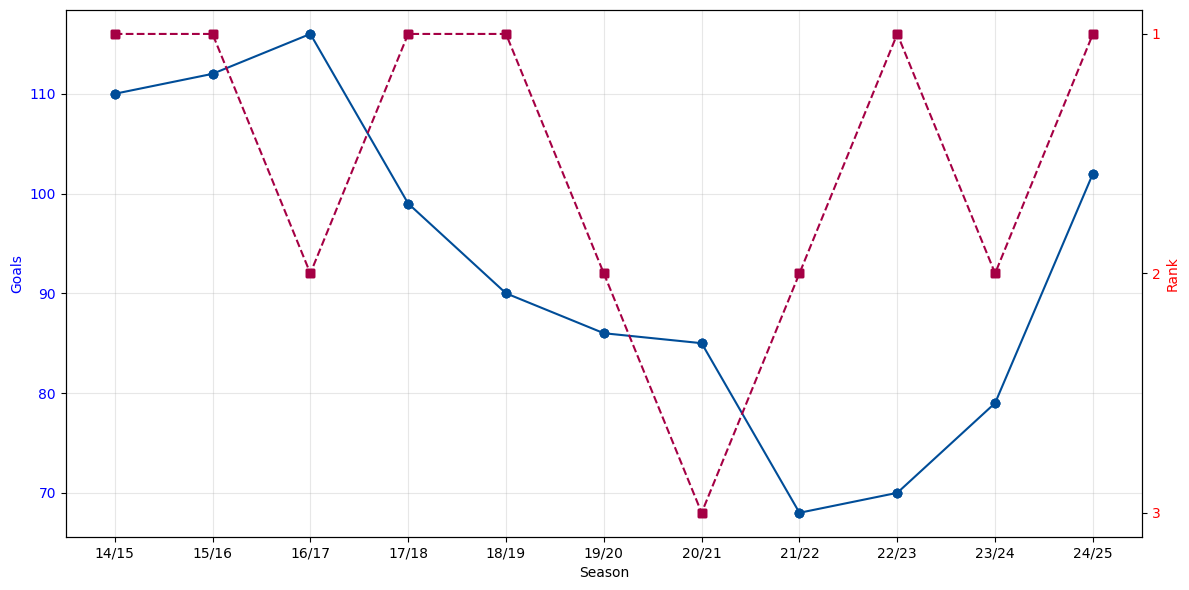

In [122]:
# Domestic stats visualize
## ========== PLOT 1: Goals & League Rank ==========
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(merged_df["Season"], merged_df["Total GF"], marker='o', color='#004D98', label="Total Goals")
ax1.set_xlabel("Season")
ax1.set_ylabel("Goals", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(alpha=0.3)

max_rank = int(merged_df["Domestic Rank"].max())
min_rank = int(merged_df["Domestic Rank"].min())

ax2 = ax1.twinx()
ax2.set_yticks(np.arange(min_rank, max_rank + 1, 1))
ax2.plot(merged_df["Season"], merged_df["Domestic Rank"], marker='s', color='#A50044', linestyle="--", label="Rank")
ax2.set_xlabel("Season")
ax2.set_ylabel("Rank", color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.invert_yaxis()
plt.tight_layout()
plt.savefig("./outputs/figures/goals_vs_rank")
plt.show()


#### Insights: How has FC Barcelona performed in domestic competitions over the past decades?
- Barcelona’s attacking output peaked between 2014–2017, after which total goals declined sharply until the low point in 2021/22.
- Despite fluctuations in goals scored, league rank did not always follow the same pattern, indicating that defensive stability and match consistency also played a crucial role in match and league outcomes.
- The 2022/23 rebound (fewer goals but improved ranking) reflects tactical restructuring, prioritizing compact defense over pure attacking output.
- The post-2023 recovery suggests a transition phase where improved squad structure outweighed raw goal production.

### Defensive Weakness Analysis
- Goals For (GF) vs Goals Against (GA)
- Goals Difference (GD)

In [123]:
## ========== PLOT 2: Goals For, Goals Against, and Goals Difference ==========
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=("Goals vs Goals Against", "Goals Difference"))

# left subplot: Goals For vs Goals Against
fig.add_trace(go.Scatter(x=merged_df['Season'], y=merged_df['Total GF'], mode='lines+markers', name='Total GF', line=dict(color='#004D98')), row=1, col=1)
fig.add_trace(go.Scatter(x=merged_df['Season'], y=merged_df['Total GA'], mode='lines+markers', name='Total GA', line=dict(color='#EDBB00')), row=1, col=1)

# right subplot: Goals Difference
fig.add_trace(go.Scatter(x=merged_df['Season'], y=merged_df['Domestic GD'], mode='lines+markers', name='Goals Difference', line=dict(color='#A50044')), row=1, col=2)

fig.update_layout(height=500, width=1200, title_text="FC Barcelona Season Metrics in La Liga")
fig.show()
fig.write_image("./outputs/figures/goals_vs_ga.png")
# fig.write_html("./outputs/html/goals_vs_ga.html")

![Goals vs GA](./outputs/figures/goals_vs_ga.png)

#### INSIGHTS: How does the number of Goals-For and Goals-Against reflect FC Barcelona defensive weakness?
- The line charts above illustrate goals distribution of FCB over the past 10 years. As shown by 2nd chart, the goal difference (goals scored - goals against) decreased gradually after 2016. This indicates that although the team maintained strong attacking numbers throughout the decade, but goals conceded increased steadily after 2016, reducing goal difference each season.
- The 2021/22 season shows the most severe imbalance: lowest goals scored + unusually high goals conceded, producing the decade’s lowest goal difference.
- The 2022/23 season marked a defensive turnaround as goals conceded dropped to a 10-year low, coinciding with managerial and tactical changes.
- However, the subsequent 23/24 season raised questions about their consistency. Despite tactical improvement, the team’s defensive performance deteriorated, with goals conceded reaching their highest level in a decade (44). This suggests that besides manager - other factors such as player dependency or financial situation - may have influenced their on-pitch performance, especially in defense.

### Finishing Efficiency (GF / xG) by Ball Situation
- 3 Ball Situations: Open Play, Free kick, Corner kick 
- Bar charts by season
- Open play vs Set piece vs Total
- Interpretation of over/underperformance

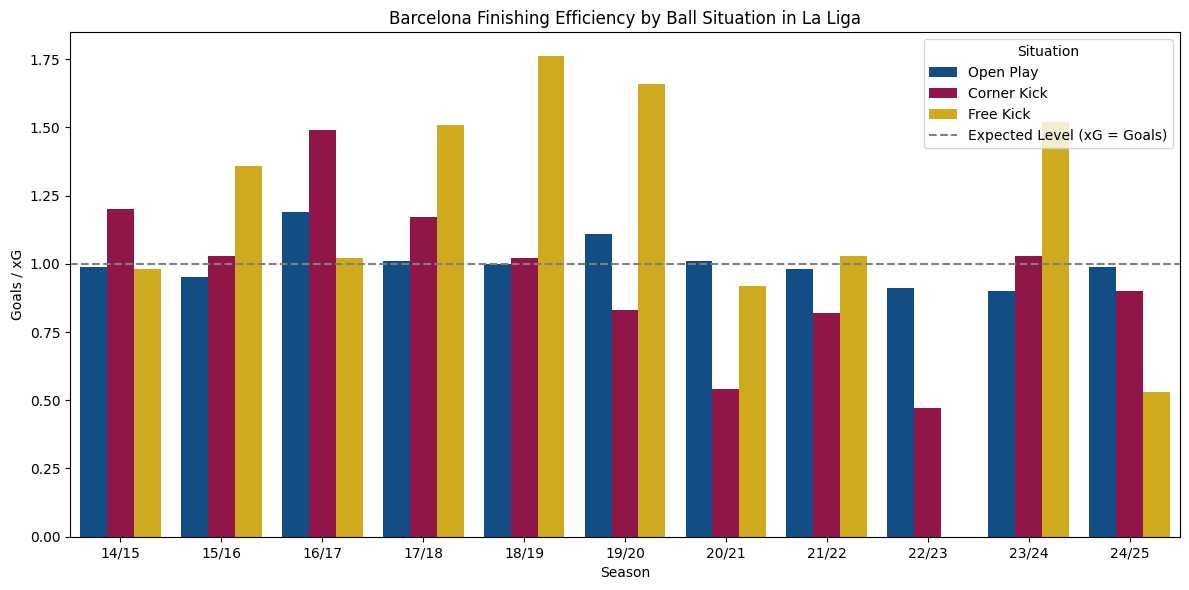

In [137]:
## ========== PLOT 3: Goals and Expected Goals ==========
plt.figure(figsize=(12, 6))

merged_df['Finishing_eff'] = (merged_df['GF'] / merged_df['xG']).round(2)

sns.barplot(x='Season', y='Finishing_eff', hue='Ball Situation', data=merged_df, palette=['#004D98','#A50044', '#EDBB00'])
plt.axhline(1, color='gray', linestyle='--', label='Expected Level (xG = Goals)')
plt.title('Barcelona Finishing Efficiency by Ball Situation in La Liga')
plt.ylabel('Goals / xG')
plt.legend(title='Situation')

plt.tight_layout()
value = merged_df.loc[merged_df["Season"] == "18/19", "Finishing_eff"].values[0]

plt.savefig("./outputs/figures/finishing_eff")


#### Insights: FC Barcelona finishing efficiency based on Expected-Goals (xG) and goals for (GF)
- The analysis of FC Barcelona finishing efficiency based on Goals-For (GF) and Expected Goals (xG) across different ball situation reveal dinstinct patterns in the team's attacking performance over the last 10 years. Efficiency is measured as the ratio of Goals-For (GF) to Expected Goals (xG), where a ratio above 1 indicates overperformance and below 1 indicates underperformance.
- **Open play:** Involving the play of live ball, usually contributes the majority of goals of any team. From **2014–2019**, Barcelona slightly overperformed xG in open play, indicating high finishing quality from elite forwards. After **2019/20**, open-play finishing efficiency dropped below 1.0, suggesting fewer clinical chances converted despite similar chance volume.
- **Set pieces:** Corner kick and freekick are usually parts of set piece but analyzing them separately will provides better understanding and visualization of their performance trend. FC Barcelona showed strong execution in dead-ball scenarios between 2014 and 2019, especially in freekick with an average of 1.38 GF/xG. However, freekick efficiency declined sharply after Messi’s departure (2020), confirming strong dependency on a single specialist.
- **Overall trend:** Overall finishing inefficiency post-2020 likely contributed to point losses in closer matches, especially when combined with defensive issues., finishing inefficiency, particularly post-2020, may have cost Barcelona decisive points both domestically and internationally. 

### International Performance — UEFA Champions League
- Stage Progression
- Total goals per Season
- Special cases (demotion to UEFA Europa League - UEL)

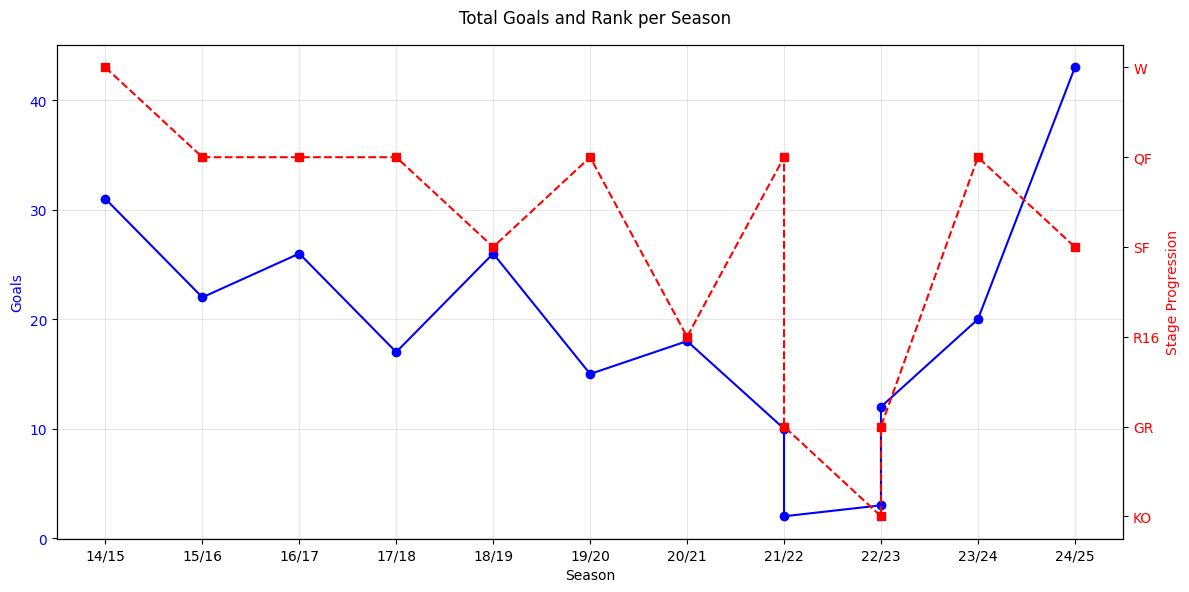

In [133]:
# stats visualize
fig, ax1 = plt.subplots(figsize=(12,6))

#========== PLOT: Goals and Rank ==========
ax1.plot(df2["Season"], df2["UCL GF"], marker='o', color='blue', label="Goals")
ax1.set_xlabel("Season")
ax1.set_ylabel("Goals", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(alpha=0.3)

# plot rank on another y axis
ax2 = ax1.twinx()  
ax2.plot(df2["Season"], df2["Stage Reached"], marker='s', color='red', linestyle='--', label="Rank")
ax2.set_ylabel("Stage Progression", color='red')
ax2.invert_yaxis()  
ax2.tick_params(axis='y', labelcolor='red')

# add title and legend
fig.suptitle("Total Goals and Rank per Season")
fig.tight_layout()

#### Insights: What about their international performance?
- Since the 2014/15 UCL title, Barcelona consistently struggled in knock-out rounds, with 8 early exits in the last 10 seasons.
- The 20221/22 & 22/23 demotions to the Europa League highlight the club’s inability to compete at group-stage intensity during its financial crisis (that's the reason why there are two points plotted in the line in these 2 seasons).
- Despite scoring enough goals in multiple seasons, defensive collapses in key matches (e.g., away legs) severely limited UCL progression.
- The 2024/25 run (high goals scored but semifinal elimination) again emphasizes a persisten weakness in defense. While their attacking performance remains strong, defensive vulnerabilities at decisive moments continue to limit their success in international competitions.

### Financial Analysis

#### Transfer Sum (€M):
- Line plot with total amount spent (in €B)
- Highlight years with high amount of spending
- Discuss poor financial management

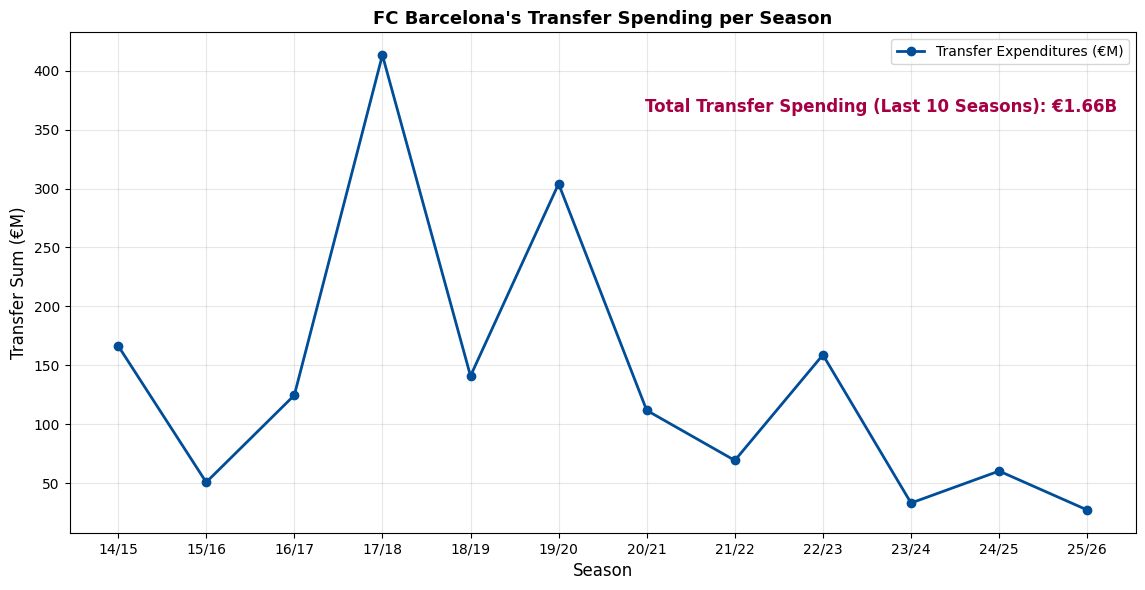

In [126]:
# Financial Analysis
## ========== PLOT 1: Transfer Spending ==========
plt.figure(figsize=(12, 6))
plt.plot(
    df5["Season"],
    df5["Transfer sum"],
    marker="o",
    color="#004D98",
    linewidth=2,
    label="Transfer Expenditures (€M)"
)

plt.title("FC Barcelona's Transfer Spending per Season", fontsize=13, weight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Transfer Sum (€M)", fontsize=12)
total_spending = df5["Transfer sum"].sum()/1000

# Add annotation
plt.text(
    0.54, 0.84, f"Total Transfer Spending (Last 10 Seasons): €{total_spending:.2f}B", transform=plt.gca().transAxes,
    fontsize=12, color="#A50044", weight='bold'
)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("./outputs/figures/transfer_expenditures.png")

#### Insight
- From 2014 to 2020, the club maintained a stable financial status, reflected in consistently high levels of transfer spending and the freedom to pursue marquee signings. Between 2016–2020, Barcelona spent over €1.1B, but major signings produced weak return on investment.
- The post-Neymar spending spike (2017/18) marks the beginning of financial instability, with multiple high-cost transfers in an attempt to replace Neymar's impact but fail to match expectations. This highlights inefficiencies in recruitment strategy, talent integration, and financial management.
- After 2020, after years of excessive spending, COVID-19 revenue losses, and structural mismanagement, had left them in severe debt, forcing reliance on free transfers and academy graduates as the results of La Liga salary cap restrictions. 
- Transfer spending patterns directly mirror the team’s performance cycle: heavy spending → inefficiency → financial collapse → rebuilding.
- Overall, this analysis demonstrates that Barcelona’s current financial struggles are not isolated incidents but rather the cumulative result of poor transfer market management during their most lavish years. The reduction in transfer expenditure after 2020 was less a matter of choice than a reflection of financial necessity, marking the beginning of a new, restrictive phase shaped by La Liga’s economic controls.


#### Squad Cost Limit
- Compare between FC Barcelona vs Real Madrid
- Year with negative limit
- Impact on transfer and performance

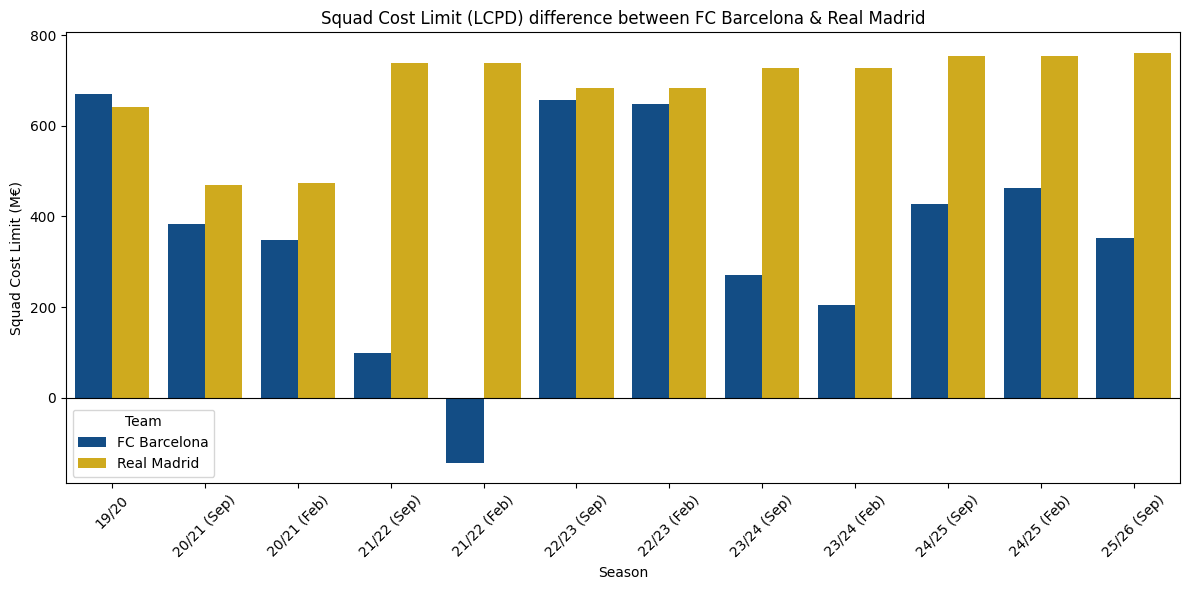

In [142]:
## ========== PLOT 2: Squad Cost Limit Comparison ==========

plt.figure(figsize=(12, 6))

palette = {'FC Barcelona': '#004D98', 'Real Madrid': '#EDBB00'}
sns.barplot(x='Season', y='Squad Cost Limit', hue='Team', data=df4, palette=palette)

plt.title('Squad Cost Limit (LCPD) difference between FC Barcelona & Real Madrid')
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('Squad Cost Limit (M€)')
plt.legend(title="Team")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("./outputs/figures/squad_cost_limit.png")

plt.show()

#### Insights: Comparison of Squad Cost Limit between FC Barcelona and Real Madrid
- The analysis of FC Barcelona's financial situation can be interpreted further by its Squad Cost Limit in La Liga compared to their rival, Real Madrid. While performance data and transfer data were available from 2014 onward, official financial data (Squad Cost Limit) is only published from 19/20 season. Squad Cost Limit (LCPD) is a measure set by La Liga which define the maximum amount a club may spend on registered players, coaching staff, and youth system expenses (including salaries, amortizations, and agent fees). 
- From 2019 to current season, FC Barcelona's Squad Cost Limit experienced major fluctuations that closely reflects their sporting performance trends:
  - Barcelona’s Squad Cost Limit collapsed from €671M (19/20) to negative levels in 21/22, forcing the club under a restrictive “1:4” - allowing only 25% reinvestment of income rule - and contributing to Messi’s departure.
  - In the 2022/23 season, the club saw a temporary recovery of the limit due to the activation of the four "economic fever", including the sales of 25% of future television rights and other assets of the club such as 49% of Barça Studio. The limit rebounded to €656M, supporting key transfer and winning the La Liga title of the season.
  - However, financing the club's future can only exchange for short-term liquidity. Although the Squad Cost Limit initially improved in 24/25, it declined slightly this current season (25/26). Unvalidated revenue from the sale of VIP seats and delayed return to the Spotify Camp Nou reduced expected income, limiting summer transfer signings. 
- Real Madrid, meanwhile, remained stable above €700M, highlighting divergent financial trajectories between the two rivals.
- **Overall**: Financial constraints correlate with performance: poorer seasons coincide with the lowest salary caps, reduced squad depth, and restricted transfer activity


### Combined Analysis (Correlation)
- Merge cleaned datasets
- Create season-level financial + performance table
- Correlation heatmap
- Scatter + regression (Squad Cost Limit vs Win Rate)ion plot with seaborn

                  Transfer sum  Squad Cost Limit  win_rate
Transfer sum          1.000000          0.714749  0.042588
Squad Cost Limit      0.714749          1.000000  0.708161
win_rate              0.042588          0.708161  1.000000


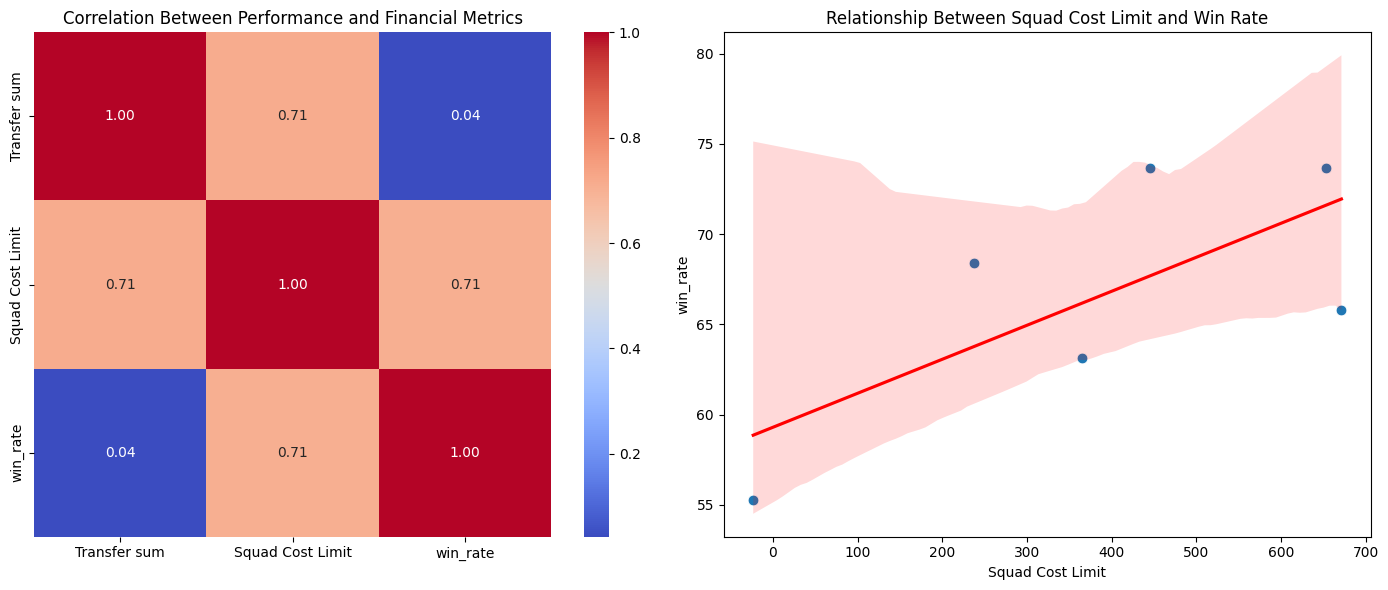

In [128]:
## ========== PLOT 3: Financial Constraints vs Team Performance ==========

## Prepare data
merged_df_single = merged_df.drop_duplicates(subset='Season').reset_index(drop=True)
merged_df_single.drop(['Squad', 'Domestic Comp', 'Ball Situation', 'GF', 'GA', 'xG', 'xGA'], axis=1, inplace=True)
merged_df_single['win_rate'] = (merged_df_single['Domestic W'] / merged_df_single['Domestic Match Played'] * 100).round(2)
merged_df_single = merged_df_single.drop(list(range(0, 5))).reset_index(drop=True)

## FC Barcelona Squad Cost Limit
fcb_df = df4[df4['Team'] == 'FC Barcelona'].copy()
fcb_df['Season_std'] = fcb_df['Season'].str[:5]
fcb_df.drop(['Season'], axis=1)
fcb_df = (fcb_df.groupby('Season_std', as_index=False)[['Squad Cost Limit']] .mean())
fcb_df.rename(columns={'Season_std' : 'Season'}, inplace=True) 

## Merge
correlation = merged_df_single.merge(fcb_df, on='Season', how='left')
summary = correlation.merge(df5, on='Season', how='left')
summary
## Correlation
numeric_cols = ['Transfer sum', 'Squad Cost Limit', 'win_rate' ]
corr = summary[numeric_cols].corr()
print(corr)

## Visualization
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[0])
axes[0].set_title("Correlation Between Performance and Financial Metrics")

ax = axes[1]
sns.scatterplot(data=summary, x='Squad Cost Limit', y='win_rate', ax=ax, s=60)
sns.regplot(data=summary, x='Squad Cost Limit', y='win_rate', ax=ax, scatter=False, color='red')
ax.set_title("Relationship Between Squad Cost Limit and Win Rate")

plt.tight_layout()
plt.show()


#### Insights
- Positive correlation between Squad Cost Limit and Win Rate, showing financial flexibility improves competitive performance. While transfer spending & win rate shows weaker correlation, reinforcing that the problem wasn’t money spent, but money spent inefficiently.
- Financial and performance variables align strongly after 2020, indicating the club’s competitive decline was deeply financial, not only tactical.
- Overall, the **correlation between financial constraints and team performance** is evident: Financial restrictions have reduced squad's depth as the club is unable to sign high-quality players, increasing dependence on current key players. FC Barcelona's challenges extends beyond tactics - the club **must restore its long-term financial stability** to rebuild their position as one of top-tier clubs and regain their competitiveness against other rivals.

In [129]:
# Interactive Dashboards
stage_map = {
    "Group": 1, "R16": 2, "QF": 3, "SF": 4, "Final": 5, "Winner": 6,
    "UEL-R16": 2, "UEL-QF": 3
}
df2["Stage Progression"] = df2["Stage Reached"].map(stage_map)

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "La Liga: Goals & Goals Against (2014–2025)",
        "UEFA Champions League Progress",
        "Transfer Spending (€M)",
        "Squad Cost Limit (€M)"
    ),
    vertical_spacing=0.12,
    horizontal_spacing=0.08,
)

## La Liga Performance - Goals & Rank
fig.add_trace(
    go.Scatter(
        x=merged_df["Season"],
        y=merged_df["Total GF"],
        mode="lines+markers",
        name="Goals For",
        line=dict(color="#004D98", width=3),
        customdata=merged_df[['Total GA','Domestic GD','Domestic Rank']],
        hovertemplate=(
            "Season: %{x}<br>"
            "Goals For: %{y}<br>"
            "Goals Against: %{customdata[0]}<br>"
            "Goals Difference: %{customdata[1]}<br>"
            "League Rank: %{customdata[2]}<extra></extra>"
        )
    )
)
fig.add_trace(
    go.Scatter(
        x=merged_df["Season"],
        y=merged_df["Total GA"],
        mode="lines+markers",
        name="Goals Against",
        line=dict(color="#A50044", width=3, dash="dot"),
        hoverinfo="skip"  
    )
)

## UCL Progress
fig.add_trace(
    go.Scatter(x=df2["Season"], y=df2["Stage Progression"], mode="lines+markers+text",
               text=df2["Stage Reached"], textposition="top center",
               name="UCL Stage Progress", line=dict(color="#A50044", width=3)),
    row=1, col=2
)

fig.update_yaxes(
    tickvals=list(stage_map.values()),
    ticktext=list(stage_map.keys()),
    row=1, col=2
)

## Transfer Spending
fig.add_trace(
    go.Bar(x=df5["Season"], y=df5["Transfer sum"],
           name="Transfer Spend", marker_color="#004D98"),
    row=2, col=1
)

# Squad cost limit
teams = df4["Team"].unique()
colors = {"FC Barcelona": "#004D98", "Real Madrid": "#EDBB00"}

for team in teams:
    team_df = df4[df4["Team"] == team]
    fig.add_trace(
        go.Bar(
            x=team_df["Season"],
            y=team_df["Squad Cost Limit"],
            name=team,
            marker_color=colors[team]
        ),
        row=2, col=2
    )

## Layout styling
fig.update_layout(
    height=900, width=1200,
    title_text="FC Barcelona: A Decade of Performance and Financial Evolution",
    showlegend=True,
    title_font=dict(size=24, color="#222", family="Arial Black"),
    plot_bgcolor="white",
    paper_bgcolor="white",
    legend=dict(x=0.5, y=-0.1, xanchor='center', orientation='h'),
    hovermode="x unified"
)

fig.show()